# Explore here

In [53]:
# Your code here

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

sns.set(
    style="whitegrid",     
    palette="pastel",              
)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv")
total_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.33,41.0,6.98,1.02,322.0,2.56,37.88,-122.23,4.53
1,8.30,21.0,6.24,0.97,2401.0,2.11,37.86,-122.22,3.58
2,7.26,52.0,8.29,1.07,496.0,2.80,37.85,-122.24,3.52
3,5.64,52.0,5.82,1.07,558.0,2.55,37.85,-122.25,3.41
4,3.85,52.0,6.28,1.08,565.0,2.18,37.85,-122.25,3.42


In [54]:
total_data.shape

(20640, 9)

In [55]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [56]:
total_data.drop_duplicates()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.33,41.0,6.98,1.02,322.0,2.56,37.88,-122.23,4.53
1,8.30,21.0,6.24,0.97,2401.0,2.11,37.86,-122.22,3.58
2,7.26,52.0,8.29,1.07,496.0,2.80,37.85,-122.24,3.52
3,5.64,52.0,5.82,1.07,558.0,2.55,37.85,-122.25,3.41
4,3.85,52.0,6.28,1.08,565.0,2.18,37.85,-122.25,3.42
...,...,...,...,...,...,...,...,...,...
20635,1.56,25.0,5.05,1.13,845.0,2.56,39.48,-121.09,0.78
20636,2.56,18.0,6.11,1.32,356.0,3.12,39.49,-121.21,0.77
20637,1.70,17.0,5.21,1.12,1007.0,2.33,39.43,-121.22,0.92
20638,1.87,18.0,5.33,1.17,741.0,2.12,39.43,-121.32,0.85


In [57]:
total_data.drop(["HouseAge", "AveRooms", "AveBedrms","Population","AveOccup","MedHouseVal"], axis = 1, inplace = True)
total_data.head()

,MedInc,Latitude,Longitude
0,8.33,37.88,-122.23
1,8.30,37.86,-122.22
2,7.26,37.85,-122.24
3,5.64,37.85,-122.25
4,3.85,37.85,-122.25


<Axes: xlabel='Longitude', ylabel='Latitude'>

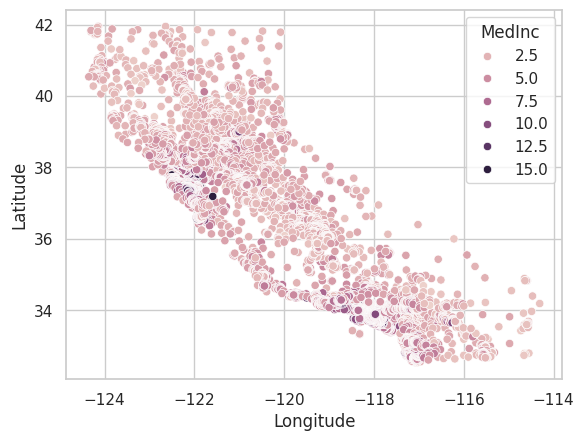

In [58]:
sns.scatterplot(data = total_data, x = 'Longitude', y = 'Latitude', hue = 'MedInc')

In [59]:
features = ['MedInc', 'Latitude', 'Longitude']
df = total_data[features].dropna()
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (16512, 3)
Test shape: (4128, 3)


In [60]:
import numpy as np
from sklearn.cluster import KMeans

model = KMeans(n_clusters=6, random_state=42, n_init=10)
model.fit(total_data)

y_test = model.predict(X_test)
y_train = model.predict(X_train)

In [62]:
total_data = df[features]

X_train['cluster'] = y_train
print(X_train['cluster'].value_counts())
print(X_train.head())


cluster
1    5544
0    3896
3    3087
5    2272
4    1345
2     368
Name: count, dtype: int64
       MedInc  Latitude  Longitude  cluster
14196    3.26     32.71    -117.03        1
8267     3.81     33.77    -118.16        1
17445    4.16     34.66    -120.48        4
14265    1.94     32.69    -117.11        1
2271     3.55     36.78    -119.80        4


<Axes: xlabel='Longitude', ylabel='Latitude'>

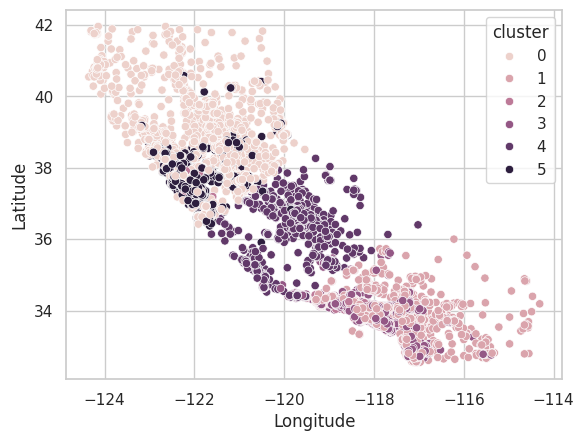

In [63]:
sns.scatterplot(
    data=X_train,
    x="Longitude",
    y="Latitude",
    hue="cluster",
)

In [64]:
total_data = df[features]

X_test['cluster'] = y_test
print(X_test['cluster'].value_counts())
print(X_test.head())


cluster
1    1467
0     953
3     753
5     526
4     338
2      91
Name: count, dtype: int64
       MedInc  Latitude  Longitude  cluster
20046    1.68     36.06    -119.01        4
3024     2.53     35.14    -119.46        4
15663    3.48     37.80    -122.44        0
20484    5.74     34.28    -118.72        3
9814     3.73     36.62    -121.93        0


<Axes: xlabel='Longitude', ylabel='Latitude'>

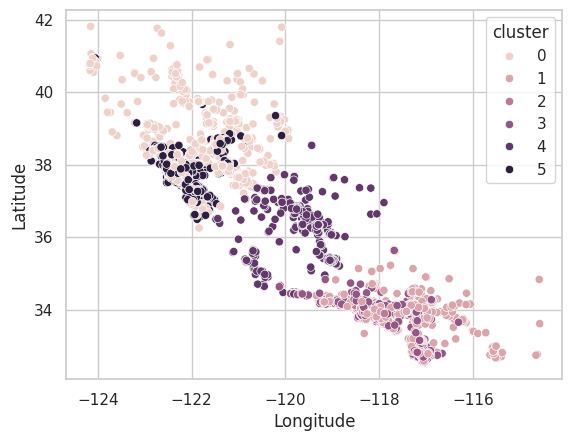

In [65]:
sns.scatterplot(
    data=X_test,
    x="Longitude",
    y="Latitude",
    hue="cluster",
)

<Axes: xlabel='Latitude', ylabel='Longitude'>

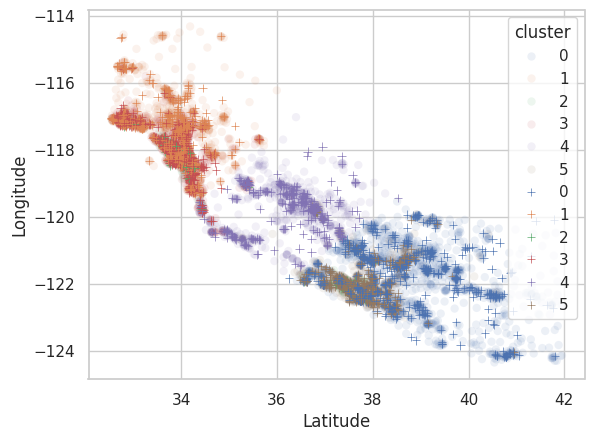

In [67]:
sns.scatterplot(data = X_train, x = "Latitude", y = "Longitude", hue = "cluster", palette = "deep", alpha  = 0.1)
sns.scatterplot(data = X_test, x = "Latitude", y = "Longitude", hue = "cluster", palette = "deep", marker = "+")


<Axes: xlabel='Longitude', ylabel='MedInc'>

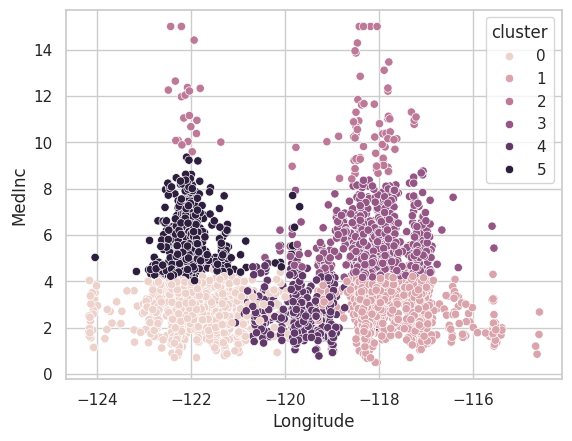

In [68]:
sns.scatterplot(
    data=X_test,
    x="Longitude",
    y="MedInc",
    hue="cluster",
)

<Axes: xlabel='Latitude', ylabel='MedInc'>

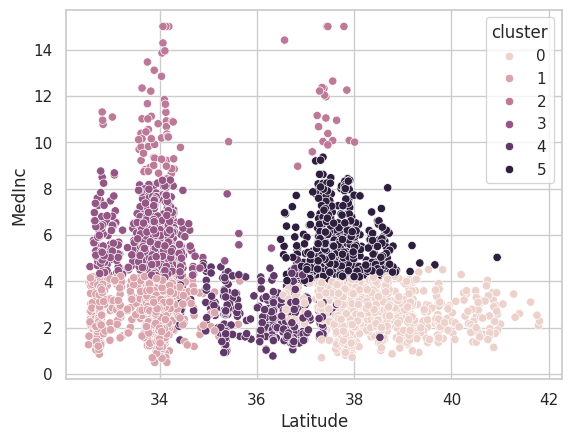

In [69]:
sns.scatterplot(
    data=X_test,
    x="Latitude",
    y="MedInc",
    hue="cluster",
)

<Axes: xlabel='Latitude', ylabel='MedInc'>

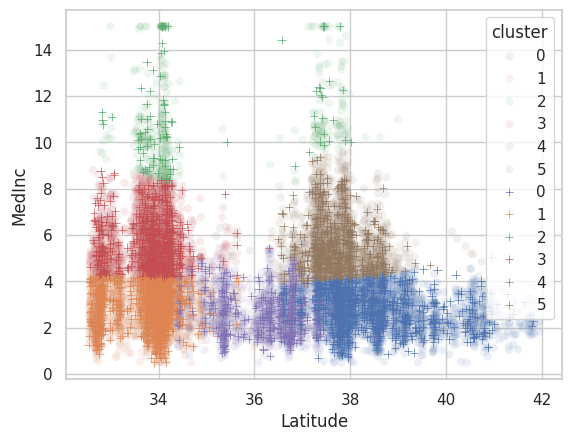

In [70]:
sns.scatterplot(data = X_train, x = "Latitude", y = "MedInc", hue = "cluster", palette = "deep", alpha  = 0.1)
sns.scatterplot(data = X_test, x = "Latitude", y = "MedInc", hue = "cluster", palette = "deep", marker = "+")

<Axes: xlabel='Longitude', ylabel='MedInc'>

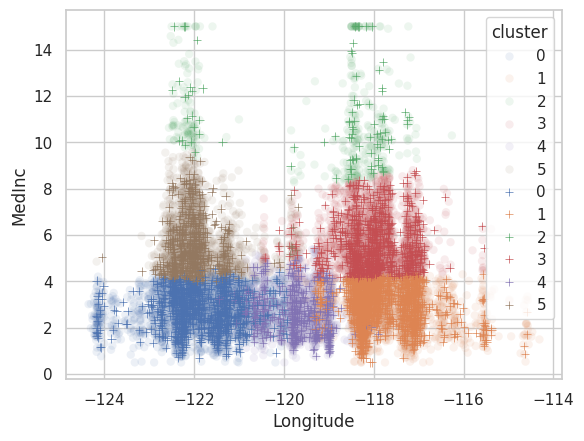

In [71]:
sns.scatterplot(data = X_train, x = "Longitude", y = "MedInc", hue = "cluster", palette = "deep", alpha  = 0.1)
sns.scatterplot(data = X_test, x = "Longitude", y = "MedInc", hue = "cluster", palette = "deep", marker = "+")